In [2]:
import os
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Data

In [28]:
fname_list = [
    "ben_260523.json",
    "jane_260523.json",
    "ken_270523.json",
    "ploy_270523.json",
    "may_270523.json",
    "paopao_270523.json",
    "raine_270523.json",
    "naenae_280523.json",
    "win_280523.json",
    "bomb_280523.json",
    # "amanda_310523.json",
    "boom_310523.json",
]
root_path = "dataset"
fname_list = [os.path.join(root_path, f) for f in fname_list]

In [29]:
data = []
for fname in fname_list:
    data += json.load(open(fname))

In [30]:
len(data)

1329

In [31]:
def report_class(data):
    label_count = {}
    for motion in data:
        label = motion["label"]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    print(label_count)

In [32]:
report_class(data)

{0: 335, 1: 331, 2: 333, 3: 330}


In [33]:
movings = [x for x in data if x["label"] == 2]

In [34]:
movings_motion = [np.array(motion["motion"])[:,:2] for motion in movings]

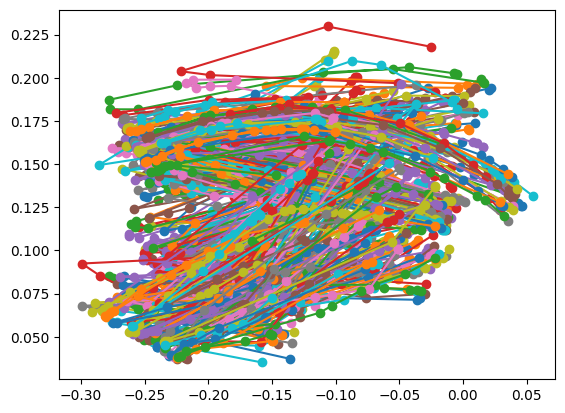

In [35]:
import matplotlib.pyplot as plt

for motion in movings_motion[:]:
    plt.plot(motion[:,0], motion[:,1], 'o-')

# Data Preprocessing

In [36]:
max_len = max([len(x['motion']) for x in data]) + 4 # find max length of the sequence to perform zero padding plus a buffer
print("Max Length : ", max_len)
num_classes = max(x['label'] for x in data) + 1 # find the total number of classes
print("Number of classes : ", num_classes)

Max Length :  44
Number of classes :  4


In [37]:
def data_augment(tmp_x, n=5):
    augment_data = []
    for i in range(n):
        offset = np.random.normal(loc=0.0, scale=0.03, size=3)
        noise = np.random.normal(loc=offset, scale=0.001, size=(tmp_x.shape[0], 3))

        tmp_x_aug = tmp_x + noise
        augment_data.append(tmp_x_aug)
    augment_data = np.stack(augment_data)
    return augment_data

In [38]:
y = []
X = []
for x in data:
    # One-hot encoder
    tmp_y = np.zeros((num_classes))
    tmp_y[x['label']] = 1.0
    y.append(tmp_y)
    
    tmp_x = np.array(x['motion'])[:,:3] # include only position x,y,z
    n_augment = 5
    augment_data = data_augment(tmp_x, n=n_augment)
    augment_data = np.concatenate([augment_data, np.zeros((augment_data.shape[0], max_len - augment_data.shape[1], augment_data.shape[2]))], axis=1)
    tmp_x = np.concatenate([tmp_x, np.zeros((max_len - tmp_x.shape[0], tmp_x.shape[1]))]) # zero padding
    # tmp_x_lag = np.concatenate([np.zeros((1, tmp_x.shape[1])), tmp_x[:-1, :]]) # lag 1
    # velocity = tmp_x - tmp_x_lag
    # tmp_x = np.concatenate([tmp_x, velocity], axis=1)
    y.extend([tmp_y] * (n_augment))
    X.append(tmp_x)
    X.extend(list(augment_data))
X = np.stack(X)
y = np.stack(y)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
print(X_train.shape)
print(X_test.shape)

(6379, 44, 3)
(1595, 44, 3)


# Model CNN

In [41]:
def make_model(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    gap = tf.keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer =tf.keras.layers.Dense(num_classes, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [42]:
model_name = "best_cnn_model.h5"
epochs = 400
batch_size = 16

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_name, save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/400
319/319 [==============================] - 2s 3ms/step - loss: 1.1699 - categorical_accuracy: 0.6085 - val_loss: 1.4010 - val_categorical_accuracy: 0.2586 - lr: 0.0010
Epoch 2/400
319/319 [==============================] - 1s 2ms/step - loss: 0.7297 - categorical_accuracy: 0.8910 - val_loss: 0.8159 - val_categorical_accuracy: 0.7719 - lr: 0.0010
Epoch 3/400
319/319 [==============================] - 1s 2ms/step - loss: 0.4627 - categorical_accuracy: 0.9312 - val_loss: 2.3873 - val_categorical_accuracy: 0.4538 - lr: 0.0010
Epoch 4/400
319/319 [==============================] - 1s 2ms/step - loss: 0.3213 - categorical_accuracy: 0.9457 - val_loss: 1.0311 - val_categorical_accuracy: 0.5251 - lr: 0.0010
Epoch 5/400
319/319 [==============================] - 1s 2ms/step - loss: 0.2412 - categorical_accuracy: 0.9543 - val_loss: 1.4100 - val_categorical_accuracy: 0.5870 - lr: 0.0010
Epoch 6/400
319/319 [==============================] - 1s 2ms/step - loss: 0.1875 - categorical_accu

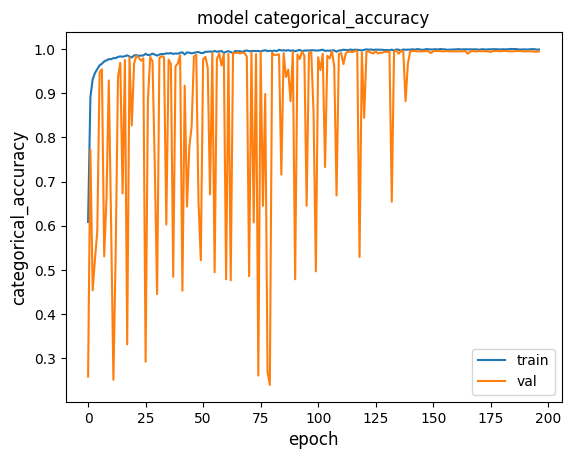

In [47]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [48]:
model = tf.keras.models.load_model(model_name)

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

50/50 [==============================] - 0s 977us/step - loss: 0.0180 - categorical_accuracy: 0.9950
Test accuracy 0.9949843287467957
Test loss 0.017963295802474022


In [49]:
from sklearn.metrics import classification_report

threshold = 0.8
y_pred = model.predict(X_test)
cond = y_pred.max(axis=1)>threshold
print(cond.mean())
y_pred_bool = np.argmax(y_pred[cond], axis=1)
y_test_bool = np.argmax(y_test[cond], axis=1)

print(classification_report(y_test_bool, y_pred_bool))

50/50 [==============================] - 0s 896us/step
0.9949843260188088
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       397
           1       0.99      1.00      0.99       386
           2       1.00      1.00      1.00       405
           3       1.00      0.99      0.99       399

    accuracy                           1.00      1587
   macro avg       1.00      1.00      1.00      1587
weighted avg       1.00      1.00      1.00      1587



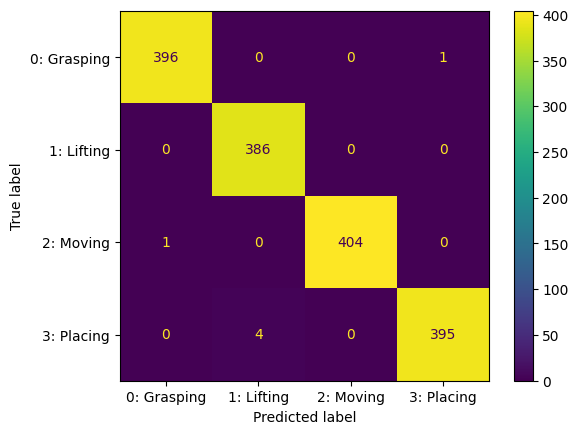

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_bool, 
                                        y_pred_bool, 
                                        display_labels=["0: Grasping","1: Lifting","2: Moving","3: Placing"],
                                        )

# Model LSTM

In [51]:
def make_model(n_features):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(200, input_shape=(None, n_features)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(200, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model


model = make_model(n_features=X_train.shape[2])

In [52]:
model_name = 'best_lstm_model.h5'
epochs = 300
batch_size = 32

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_name, save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/300
160/160 [==============================] - 12s 55ms/step - loss: 1.3650 - categorical_accuracy: 0.2998 - val_loss: 1.3677 - val_categorical_accuracy: 0.3448 - lr: 0.0010
Epoch 2/300
160/160 [==============================] - 10s 61ms/step - loss: 1.3392 - categorical_accuracy: 0.3402 - val_loss: 1.3515 - val_categorical_accuracy: 0.3409 - lr: 0.0010
Epoch 3/300
160/160 [==============================] - 6s 36ms/step - loss: 1.3229 - categorical_accuracy: 0.3537 - val_loss: 1.3540 - val_categorical_accuracy: 0.3260 - lr: 0.0010
Epoch 4/300
160/160 [==============================] - 5s 34ms/step - loss: 1.3157 - categorical_accuracy: 0.3680 - val_loss: 1.2854 - val_categorical_accuracy: 0.3668 - lr: 0.0010
Epoch 5/300
160/160 [==============================] - 5s 33ms/step - loss: 1.2244 - categorical_accuracy: 0.4380 - val_loss: 1.0279 - val_categorical_accuracy: 0.5862 - lr: 0.0010
Epoch 6/300
160/160 [==============================] - 5s 33ms/step - loss: 1.0105 - categori

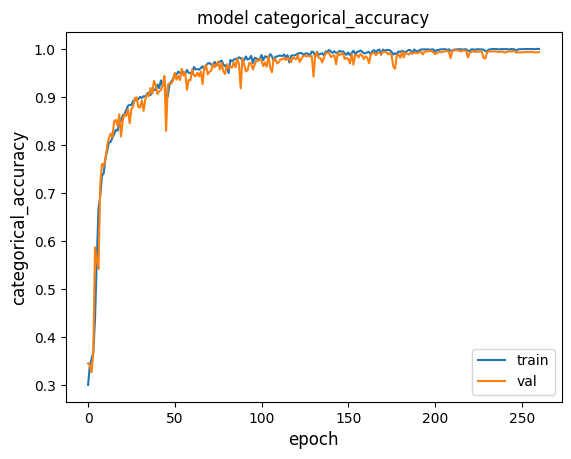

In [57]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [58]:
model = tf.keras.models.load_model(model_name)

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

50/50 [==============================] - 1s 10ms/step - loss: 0.0148 - categorical_accuracy: 0.9931
Test accuracy 0.9931034445762634
Test loss 0.014763673767447472


In [59]:
from sklearn.metrics import classification_report

threshold = 0.8
y_pred = model.predict(X_test)
cond = y_pred.max(axis=1)>threshold
print(cond.mean())
y_pred_bool = np.argmax(y_pred[cond], axis=1)
y_test_bool = np.argmax(y_test[cond], axis=1)

print(classification_report(y_test_bool, y_pred_bool))

50/50 [==============================] - 1s 8ms/step
0.9924764890282132
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       397
           1       0.99      1.00      1.00       385
           2       1.00      1.00      1.00       406
           3       1.00      1.00      1.00       395

    accuracy                           1.00      1583
   macro avg       1.00      1.00      1.00      1583
weighted avg       1.00      1.00      1.00      1583



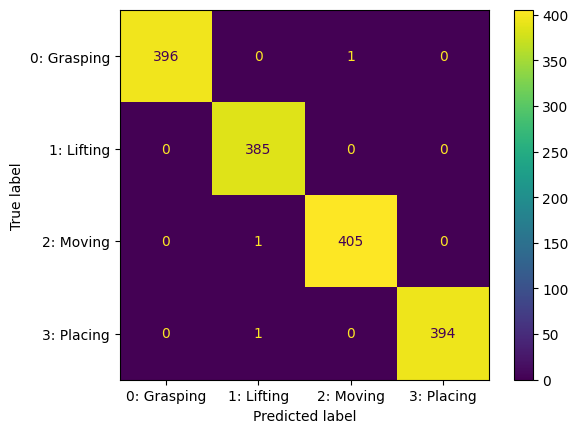

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_bool, 
                                        y_pred_bool, 
                                        display_labels=["0: Grasping","1: Lifting","2: Moving","3: Placing"],
                                        )